<a href="https://colab.research.google.com/github/ugThaminduD/ML__IT4060__Lab2/blob/main/DeliveryGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install deap
# uncomment and run the first time as most probably deap library may not be already installed

In [10]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# -----------------------------------
# STEP 1: Problem Definition
# -----------------------------------
# We need to optimize a delivery route by minimizing total travel distance.
# The warehouse is at index 0, and we must visit all locations exactly once.

# Distance matrix representing the travel cost between locations
distance_matrix = np.array([
    [0, 10, 15, 20, 25, 30],  # Warehouse
    [10, 0, 35, 25, 30, 20],  # Location 1
    [15, 35, 0, 30, 20, 25],  # Location 2
    [20, 25, 30, 0, 15, 10],  # Location 3
    [25, 30, 20, 15, 0, 35],  # Location 4
    [30, 20, 25, 10, 35, 0]   # Location 5
])

num_locations = len(distance_matrix)  # Total locations (including warehouse)
population_size = 10   # Number of candidate solutions in each generation
generations = 100      # Number of iterations
mutation_rate = 0.2    # Probability of mutation

# -----------------------------------
# STEP 2: Genetic Algorithm Setup
# -----------------------------------
# We define a DEAP "FitnessMin" class to represent our objective (minimize distance).
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize distance
creator.create("Individual", list, fitness=creator.FitnessMin)  # A delivery route is a list of locations

toolbox = base.Toolbox()

# Function to generate a valid random route (excluding warehouse)
def create_valid_route():
    """Creates a shuffled list of locations excluding the warehouse (index 0)."""
    route = list(range(1, num_locations))  # Locations 1 to num_locations-1
    random.shuffle(route)  # Shuffle locations randomly
    return creator.Individual(route)  # Return as DEAP Individual

toolbox.register("individual", tools.initIterate, creator.Individual, create_valid_route)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


preferred_times = [2, 4, 1, 3, 5]  # Preferred delivery order slots for locations 1..5
penalty_per_late = 5               # Distance-equivalent penalty per slot late


# -----------------------------------
# STEP 3: Fitness Function (Objective Function)
# -----------------------------------
# The fitness function calculates the total travel distance for a given route.
# def route_distance(individual):
#     """Computes total travel distance for a given route."""
#     route = [0] + individual + [0]  # Start and end at the warehouse
#     total_distance = sum(distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1))
#     return total_distance,  # Return as a tuple (DEAP requires tuple format)

# toolbox.register("evaluate", route_distance)

def route_distance(individual):
    """Computes total travel distance for a given route, with lateness penalty."""
    route = [0] + individual + [0]  # Start and end at the warehouse
    total_distance = sum(distance_matrix[route[i], route[i + 1]] for i in range(len(route) - 1))

    # Arrival order-based time penalty (1-based position in the tour)
    lateness = 0
    for idx, loc in enumerate(individual, start=1):  # positions 1..len(individual)
        preferred = preferred_times[loc - 1]         # loc is 1..5; convert to 0-based index
        if idx > preferred:
            lateness += (idx - preferred) * penalty_per_late

    fitness = total_distance + lateness
    return fitness,  # Return as a tuple

toolbox.register("evaluate", route_distance)

# -----------------------------------
# TODO: Extend the Lab (Student Task)
# -----------------------------------
# Modify the fitness function to include time constraints.
# Steps:
# 1. Assume each location has a preferred delivery time slot (e.g., [2, 4, 1, 3, 5]).
# 2. Penalize routes that visit locations later than their required time.
# 3. Modify the `route_distance` function to include a penalty.
# 4. Re-run the genetic algorithm and analyze changes in the best route.


# -----------------------------------
# STEP 4: Genetic Algorithm Operators
# -----------------------------------
# Crossover: Uses Partially Mapped Crossover (PMX) to swap sections between two parents
def custom_pmx(ind1, ind2):
    """Applies PMX crossover after converting to 0-based indices, then converts back."""
    ind1[:] = [x - 1 for x in ind1]  # Convert to 0-based indices
    ind2[:] = [x - 1 for x in ind2]

    tools.cxPartialyMatched(ind1, ind2)  # Apply PMX crossover

    ind1[:] = [x + 1 for x in ind1]  # Convert back to 1-based indices
    ind2[:] = [x + 1 for x in ind2]
    return ind1, ind2  # Return modified individuals

toolbox.register("mate", custom_pmx)  # Crossover function
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mutation_rate)  # Mutation: Swap elements
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection: Tournament method

# -----------------------------------
# STEP 5: Genetic Algorithm Execution
# -----------------------------------
def genetic_algorithm():
    """Executes the Genetic Algorithm to find the optimal delivery route."""
    population = toolbox.population(n=population_size)  # Create initial population

    # Run the genetic algorithm for a set number of generations
    for generation in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=mutation_rate)  # Apply crossover & mutation
        population = toolbox.select(offspring, k=len(population))  # Select best individuals for next generation

    # Return the best solution found
    best_route = tools.selBest(population, k=1)[0]  # Get best route
    best_distance = route_distance(best_route)[0]  # Compute total distance
    return best_route, best_distance

# Run the genetic algorithm
best_route, best_distance = genetic_algorithm()

# -----------------------------------
# STEP 6: Print Results
# -----------------------------------
print("Best Delivery Route:", [0] + best_route + [0])  # Add warehouse start/end
print("Minimum Distance:", best_distance)


Best Delivery Route: [0, 5, 1, 2, 3, 4, 0]
Minimum Distance: 180


In [11]:
# Write the answers to the questions here

1. Before modifying the fitness function, what was the optimal route and distance?
* The best route and distance (no penalty term).

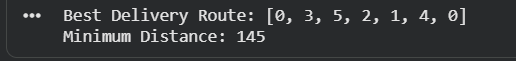
***
2. After including time constraints, how did the route change? Did the cost increase?
* The best route, total distance, lateness penalty, and combined fitness. Mention if the route changed and whether the cost (fitness) increased.

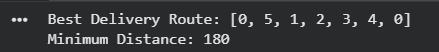
***
3. What happens when you increase the number of generations? What happens when you update the mutation rate, or change the size of the population? Briefly explain the observations.
* more generations/population → better solutions but slower
* higher mutation → more exploration, too high can destabilize
* lower mutation → risk of premature convergence